Libraries

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, classification_report, confusion_matrix

# Ignore warnings ,  Define dataset paths,  Check if files exist , Load Data

In [3]:
warnings.filterwarnings('ignore')

dataset_train = r"E:\Graduation-Project\NIDS\dataset\UNSW-NB15\UNSW_NB15_training-set.csv"
dataset_test = r"E:\Graduation-Project\NIDS\dataset\UNSW-NB15\UNSW_NB15_testing-set.csv"

if not os.path.exists(dataset_train) or not os.path.exists(dataset_test):
    raise FileNotFoundError("One or both dataset files are missing!")

df_train = pd.read_csv(dataset_train)
df_test = pd.read_csv(dataset_test)
df = pd.concat([df_train, df_test]).reset_index(drop=True)

del df_train, df_test

Drop irrelevant columns , Feature Clamping (Remove extreme values) , Apply Log Transformation , Encoding Categorical Features using Target Encoding , Feature Selection , Split Data , Standardization

In [4]:
df.drop(columns=['id', 'attack_cat'], inplace=True)

df_numeric = df.select_dtypes(include=[np.number])
for feature in df_numeric.columns:
    if df[feature].max() > 10 * df[feature].median():
        df[feature] = np.where(df[feature] < df[feature].quantile(0.95), df[feature], df[feature].quantile(0.95))

for feature in df_numeric.columns:
    if df[feature].nunique() > 50:
        df[feature] = np.log1p(df[feature])

encoder = TargetEncoder()
df[['proto', 'service', 'state']] = encoder.fit_transform(df[['proto', 'service', 'state']], df['label'])

X = df.drop(columns=['label'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Build Deep Learning Model , Compile Model , Train Model , Evaluate Model

In [5]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
end_train = time.time()

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred, average='weighted')

print("\nDeep Learning Model Performance:")
print("Accuracy: {:.2%}".format(accuracy))
print("Recall: {:.2%}".format(recall))
print("Precision: {:.2%}".format(precision))
print("F1-Score: {:.2%}".format(f1s))
print("Training Time: {:.2f}s".format(end_train - start))
print("Prediction Time: {:.2f}s".format(end_predict - end_train))

Epoch 1/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.8839 - loss: 0.2303 - val_accuracy: 0.9156 - val_loss: 0.1565
Epoch 2/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9172 - loss: 0.1581 - val_accuracy: 0.9265 - val_loss: 0.1457
Epoch 3/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9222 - loss: 0.1509 - val_accuracy: 0.9275 - val_loss: 0.1418
Epoch 4/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9251 - loss: 0.1462 - val_accuracy: 0.9290 - val_loss: 0.1404
Epoch 5/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9244 - loss: 0.1479 - val_accuracy: 0.9304 - val_loss: 0.1387
Epoch 6/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9272 - loss: 0.1436 - val_accuracy: 0.9331 - val_loss: 0.1351
Epoch 7/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9280 - loss: 0.1422 - val_accuracy: 0.9323 - val_loss: 0.1342
Epoch 8/20
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9296 - loss: 0

# Confusion Matrix , ROC Curve , Classification Report

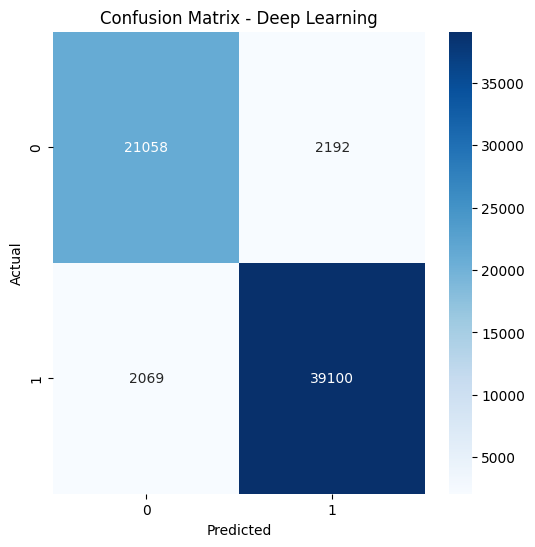

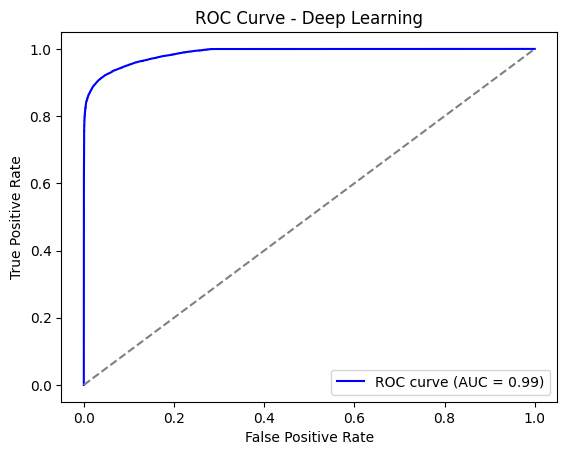


Classification Report - Deep Learning:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     23250
           1       0.95      0.95      0.95     41169

    accuracy                           0.93     64419
   macro avg       0.93      0.93      0.93     64419
weighted avg       0.93      0.93      0.93     64419



In [6]:
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Deep Learning')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - Deep Learning')
plt.show()

print("\nClassification Report - Deep Learning:\n", classification_report(y_test, y_pred))